# Constructing a Multivariate sensitivity analysis

# Preliminaries
## Importing packages

In [1]:
import numpy as np
import pandas as pd
from itertools import product

import seaborn as sns
#sns.set()
#sns.set_style('whitegrid')
#sns.set_context('notebook')
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from thesis_EAfunc import *
from thesis_visfunc import *

In [2]:
import datetime
time_a = datetime.datetime.now()
print(time_a)

2019-05-12 16:01:34.921627


# Define Landscape

In [3]:
#Problem domain
x_min = -15
x_max = 15
y_min = -15
y_max = 15

#Known minimum
x_point = -6.01717
y_point = 9.06022

domain = (x_min, x_max, y_min, y_max)
point = (x_point, y_point)
img_size = (8.5, 4.25)

#Problem definition
import math
def g(x,y):
    mag = np.sqrt(x**2. + y**2.)
    return -(50.*np.sinc(mag/np.pi) - mag)

def f(x, y):
    x_min = -6.01717
    y_min = 9.06022
    f_min = g(x_min+11., y_min+9.) + g(x_min-11., y_min-3.) + g(x_min+6., y_min-9.)
    tripsinc = g(x+11., y+9.) + g(x-11., y-3.) + g(x+6., y-9.) - (f_min)
    return tripsinc

#Testing the minimum
print(f(-1,-1), f(-11,-9), f(11,3), f(-6,9))
print()
print(f(-6.01717, 9.06022))

50.62059878583003 5.177364279021976 6.107247239602234 0.031278340140559635

0.0


# Running the Evolutionary Algorithm
Experiments -> Each trial with a different mutation probability and mutation size -> Each trial with 50 runs
## Setting the EA's parameters

In [4]:
#starting seed
np.random.seed(42)

## Setting data storage

In [5]:
mult_fit_cols = ['exp'] + ['mut_s'] + ['mut_p'] + ['run', 'generation', 'fitness_min', 'fitness_max', 'fitness_mean', 'fitness_std']
multi_fit = pd.DataFrame(columns=mult_fit_cols)
multi_fit = multi_fit.infer_objects()

multi_gen_cols = ['exp'] + ['mut_s'] + ['mut_p'] + ['run', 'birthdate', 'generation', 'function', 'fitness', 'gen_x', 'gen_y']
multi_gen = pd.DataFrame(columns=multi_gen_cols)
multi_gen = multi_gen.infer_objects()

## Parameters common to all experiments

In [6]:
#Algorithm parameters
## Number of experiments, and generations per experiment
run_n = 50
gen_f = 40

## Population size
pop_s = 20

## Parent subpopulation's selection method and size
par_selection = 'fitness_proportional_selection'
par_s = 60

## Progeny subpopulation's and size
prog_s = par_s
### Crossover Method
crossover = 'uniform'
### Mutation method, probability and size
mutation = 'random_all_gau_dis'
mut_p = [0.1, 0.25, 0.5, 0.75, 0.9]
mut_s = [.1, .5, 1, 5, 10]

## New population selection method
population_new='tournament_k3'

## Iterative experiment

In [7]:
print()
print(mut_p)
print(mut_s)
exp_par = list(product(mut_p,mut_s))
print(exp_par)


[0.1, 0.25, 0.5, 0.75, 0.9]
[0.1, 0.5, 1, 5, 10]
[(0.1, 0.1), (0.1, 0.5), (0.1, 1), (0.1, 5), (0.1, 10), (0.25, 0.1), (0.25, 0.5), (0.25, 1), (0.25, 5), (0.25, 10), (0.5, 0.1), (0.5, 0.5), (0.5, 1), (0.5, 5), (0.5, 10), (0.75, 0.1), (0.75, 0.5), (0.75, 1), (0.75, 5), (0.75, 10), (0.9, 0.1), (0.9, 0.5), (0.9, 1), (0.9, 5), (0.9, 10)]


In [8]:
%%time
exp_n = 1
for (xx,yy) in exp_par:
    genera_res, fitness_res = EA_exp(run_n, gen_f, f, domain, pop_s, par_s, prog_s, xx, yy, par_selection, crossover, mutation, population_new)
    
    fitness_res.insert(0,'mut_p',xx)
    fitness_res.insert(0,'mut_s',yy)
    fitness_res.insert(0,'exp',exp_n)
    multi_fit = multi_fit.append(fitness_res, ignore_index=True, sort=False)
    multi_fit = multi_fit.infer_objects()
    
    genera_res.insert(0,'mut_p',xx)
    genera_res.insert(0,'mut_s',yy)
    genera_res.insert(0,'exp',exp_n)
    multi_gen = multi_gen.append(genera_res, ignore_index=True, sort=False)
    multi_gen = multi_gen.infer_objects()
        
    exp_n += 1

Wall time: 21min 28s


In [9]:
multi_fit.to_pickle('./EA_B_04_fit.gz', compression='gzip')
multi_gen.to_pickle('./EA_B_04_gen.gz', compression='gzip')

In [10]:
multi_fit = pd.read_pickle('./EA_B_04_fit.gz', compression='gzip')
multi_gen = pd.read_pickle('./EA_B_04_gen.gz', compression='gzip')

In [11]:
time_b = datetime.datetime.now()
print(time_b)
print(time_b-time_a)

2019-05-12 16:23:45.550812
0:22:10.629185


# Data analysis

In [12]:
query = (multi_fit['generation']==gen_f)
multi_final_fitness_res = multi_fit[query].apply(pd.to_numeric)

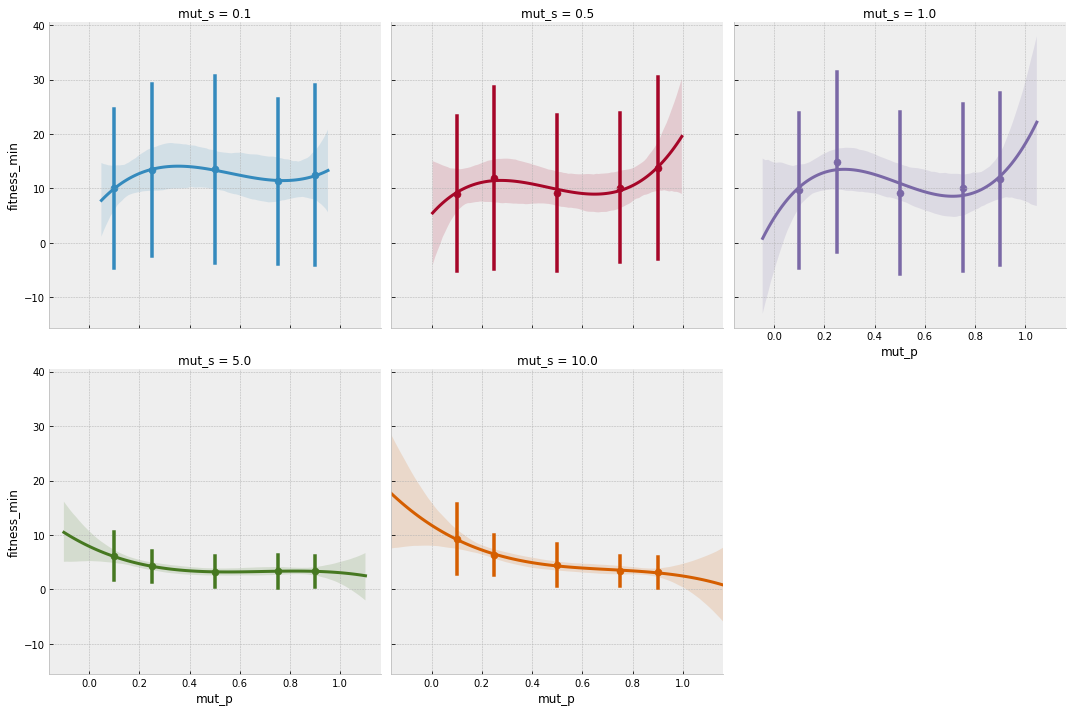

In [13]:
sns.lmplot(x='mut_p', y='fitness_min', order=3, data=multi_final_fitness_res,hue='mut_s', col='mut_s', x_bins=5, col_wrap=3, x_ci='sd')

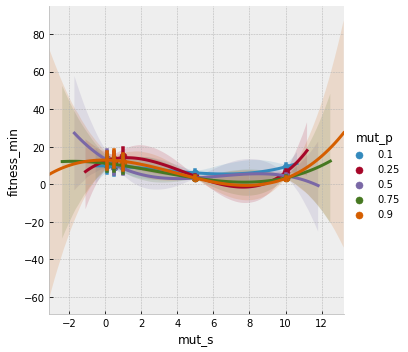

In [14]:
sns.lmplot(x='mut_s', y='fitness_min', order=3, data=multi_final_fitness_res,hue='mut_p', x_bins=5)

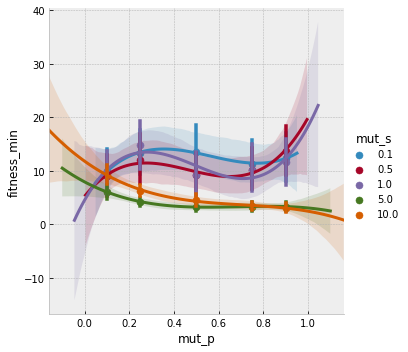

In [15]:
sns.lmplot(x='mut_p', y='fitness_min', order=3, data=multi_final_fitness_res,hue='mut_s', x_bins=5)

In [16]:
time_c = datetime.datetime.now()
print(time_c)
print(time_c-time_a)

2019-05-12 16:24:00.365142
0:22:25.443515


In [17]:
multi_fit.info()
print()
multi_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51250 entries, 0 to 51249
Data columns (total 9 columns):
exp             51250 non-null int64
mut_s           51250 non-null float64
mut_p           51250 non-null float64
run             51250 non-null int64
generation      51250 non-null float64
fitness_min     51250 non-null float64
fitness_max     51250 non-null float64
fitness_mean    51250 non-null float64
fitness_std     51250 non-null float64
dtypes: float64(7), int64(2)
memory usage: 3.5 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4025000 entries, 0 to 4024999
Data columns (total 10 columns):
exp           int64
mut_s         float64
mut_p         float64
run           int64
birthdate     float64
generation    float64
function      object
fitness       float64
gen_x         float64
gen_y         float64
dtypes: float64(7), int64(2), object(1)
memory usage: 307.1+ MB


In [18]:
multi_final_fitness_res.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1250 entries, 40 to 51249
Data columns (total 9 columns):
exp             1250 non-null int64
mut_s           1250 non-null float64
mut_p           1250 non-null float64
run             1250 non-null int64
generation      1250 non-null float64
fitness_min     1250 non-null float64
fitness_max     1250 non-null float64
fitness_mean    1250 non-null float64
fitness_std     1250 non-null float64
dtypes: float64(7), int64(2)
memory usage: 97.7 KB
